# DENOISING AUTOENCODER FOR MIDI

### **0. TODOs**

1. ~~Fix random dropped samples during shifting~~
  (solution: can't v-shift enough times if the parent sample occupies too much of the available v-space)
2. ~~Fix `tqdm` stuff~~
3. ~~change generated/saved temp images to be NP arrays instead of .PNGs, that's stupid~~
4. ~~get overfitting working~~
5. ~~clean up review pipeline~~
6. update load libraries section below
7. clean up shift -> noising double double-for loops, unnecessary
8. add variable velocity scaling to augmentation step

### **1. Load Libraries**

The imported modules include:

* `torchvision`: contains many popular computer vision datasets, deep neural network architectures, and image processing modules. We will use this to download the CIFAR10 dataset.
* `torch.nn`: contains the deep learning neural network layers such as `Linear()`, and `Conv2d()`.
* `transforms`: will help in defining the image transforms and normalizations.
* `optim`: contains the deep learning optimizer classes such as `MSELoss()` and many others as well.
* `functional`: we will use this for activation functions such as ReLU.
* `DataLoader`: eases the task of making iterable training and testing sets.

In [15]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# torchvision
from torchinfo import summary
from torchvision.utils import save_image

# other
import os
import time
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

#### Dark theme

In [16]:
plt.style.use("dark_background")

In [17]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

### **2. Define Constants**

In [18]:
# constants
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.01
NUM_PERMUTATIONS = 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### **3. Helper Functions**

In [19]:
def make_dir():
    image_dir = "images"
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)

In [20]:
def compare_plot(a1, a2, t1="noisy", t2="denoised"):
    plt.figure(figsize=(8, 3))
    plt.subplot(2, 1, 1)
    plt.title(t1)
    plt.imshow(
        np.squeeze(a1),
        aspect="auto",
        origin="lower",
        cmap="magma",
        interpolation="nearest",
    )
    plt.axis("off")
    plt.subplot(2, 1, 2)
    plt.title(t2)
    plt.imshow(
        np.squeeze(a2),
        aspect="auto",
        origin="lower",
        cmap="magma",
        interpolation="nearest",
    )
    plt.axis("off")
    plt.show()

In [21]:
def count_nested_items(nested_dict):
    """
    Counts the total number of items in a 1-level deep nested dictionary.

    Parameters:
    nested_dict (dict): A dictionary with nested dictionaries as values.

    Returns:
    int: Total number of items in the nested dictionaries.

    chatGPT
    """
    total_items = 0
    # Iterate through each value in the top-level dictionary
    for value in nested_dict.values():
        # Check if the value is a dictionary itself
        if isinstance(value, list):
            # Add the number of items in the nested dictionary to the total
            total_items += len(value)
    return total_items

### **4. Load Data**

In [22]:
clean_images = np.load("all_loops.npz")

### **5. Prepare the Data**

In [23]:
def shift_array_v(arr, down_max, up_max):
    # !!!SHIFTS ARE INVERTED!!!
    # Determine the shift direction and magnitude
    # Positive for down, negative for up
    shift_magnitude = random.randint(-up_max, down_max)
    # print(f"(dmax = {down_max}, umax = {up_max}) | shifting notes {'up' if shift_magnitude < 0 else 'down'} {shift_magnitude}")

    num_rows, num_cols = arr.shape

    if shift_magnitude > 0:  # Shift down
        shifted_arr = np.vstack(
            (arr[shift_magnitude:], np.zeros((shift_magnitude, num_cols)))
        )
    elif shift_magnitude < 0:  # Shift up
        shifted_arr = np.vstack(
            (np.zeros((-shift_magnitude, num_cols)), arr[: num_rows + shift_magnitude])
        )
    else:  # No shift
        shifted_arr = arr

    return shifted_arr, shift_magnitude

In [24]:
def format_image(image):
    image = np.delete(image, 0, axis=1)
    image = torch.from_numpy(np.expand_dims(image, 0)).to(torch.float32)
    if torch.any(image > 1.0):
        image = image / image.max()
    image = F.pad(input=image, pad=(0, 12, 1, 1), mode="constant", value=0.0)

    return image

In [25]:
# def noise_images(images, num=1):
#     noisy_images = []  # {}
#     bad_images = []
#     for name, image in list(images.items()):
#         time_factor = image[:, 0]  # save time factor
#         image = np.delete(image, 0, axis=1)  # remove it from the image though
#         # print(f"Noising {name} -> {image.shape} w min {round(np.min(image), 2)} and max {round(np.max(image), 2)}")
#         for _ in range(num):
#             # shift notes up/down
#             # non_zero_rows_mask = np.any(image != 0, axis=1)
#             # lowest_index = np.where(non_zero_rows_mask)[0][0]
#             # highest_index = np.where(non_zero_rows_mask)[0][-1]
#             # noisy_image, _ = shift_array_v(
#             #     image, lowest_index, image.shape[0] - highest_index - 1
#             # )

#             # rescale velocities
#             scaled_vel = noisy_image / np.max(noisy_image)

#             # corrupt image
#             noisy_image = torch.from_numpy(noisy_image) + NOISE_FACTOR * np.clip(
#                 torch.randn_like(image.shape), np.min(image), np.max(image)
#             )

#             # check image integrity
#             if torch.isnan(noisy_image).any():
#                 print(f"Ouch! broke while noising {name}")
#                 bad_images.append(name)
#                 continue

#             # reformat
#             noisy_image = torch.from_numpy(np.expand_dims(noisy_image, 0)).to(
#                 torch.float32
#             )
#             if torch.any(noisy_image > 1.0):
#                 noisy_image = noisy_image / noisy_image.max()
#             noisy_image = F.pad(
#                 input=noisy_image, pad=(0, 12, 1, 1), mode="constant", value=0
#             )

#             # dict approach
#             # if name not in noisy_images.keys():
#             #     noisy_images[name] = []
#             # noisy_images[name].append(noisy_image)
#             # array approach
#             noisy_images.append((name, noisy_image))
#             # print(f"Noised {name} -> {noisy_image.shape} w min {round(np.min(np.array(noisy_image)), 2)} and max {round(np.max(np.array(noisy_image)), 2)}")

#     return noisy_images, bad_images

In [26]:
# aug_factor = 5
# shifted_images = {}
# for name, image in clean_images.items():
#     for _ in range(aug_factor):
#         non_zero_rows_mask = np.any(image != 0, axis=1)
#         lowest_index = np.where(non_zero_rows_mask)[0][0]
#         highest_index = np.where(non_zero_rows_mask)[0][-1]

#         # avoid repeated magnitude
#         shifted_image, mag = shift_array_v(
#             image, lowest_index, image.shape[0] - highest_index - 1
#         )
#         new_key = f"{Path(name).stem}_{'u' if mag < 0 else 'd'}{np.abs(mag):02d}"
#         # while new_key in shifted_images.keys():
#         #     print(f"key {new_key} already found in dict, retrying")
#         #     shifted_image, mag = shift_array_v(
#         #         image, lowest_index, image.shape[0] - highest_index - 1
#         #     )
#         #     new_key = f"{Path(name).stem}_{'u' if mag < 0 else 'd'}{np.abs(mag):02d}"

#         shifted_images[new_key] = shifted_image

# print(
#     f"used {len(list(clean_images.keys()))} images to generate {len(shifted_images.keys())} shifted images"
# )
# noisy_images, trouble = noise_images(shifted_images, aug_factor)
# print(
#     f"used {len(list(shifted_images.keys()))} shifted images to generate {len(noisy_images)} noisy images"
# )

In [27]:
def augment_data(data, num_permutations=2, out_file=None):
    """Augments a set of passed-in images by a factor of 2*num_permutations"""
    shifted_images = {}
    # noisy_images = {} # dict
    noisy_images = []  # array

    for name, image in tqdm(list(data.items()), unit="images", dynamic_ncols=True):
        time_factor = image[:, 0]  # save time factor
        # image = np.delete(image, 0, axis=1)  # remove it from the image though
        # print(f"Noising up {name} @t{time_factor[0]}")

        # make num_permutations vertically shifted images
        for _ in range(num_permutations):
            # vertical shift images
            non_zero_rows_mask = np.any(image != 0, axis=1)
            lowest_index = np.where(non_zero_rows_mask)[0][0]
            highest_index = np.where(non_zero_rows_mask)[0][-1]

            shifted_image, mag = shift_array_v(
                image, lowest_index, image.shape[0] - highest_index - 1
            )
            new_key = f"{Path(name).stem}_{'u' if mag < 0 else 'd'}{np.abs(mag):02d}"

            # avoid repeated magnitudes
            num_tries = 0  # prevent infinite loops
            while new_key in shifted_images.keys() and num_tries <= num_permutations:
                num_tries += 1
                if num_tries == num_permutations:
                    print(
                        f"failed on {name} {lowest_index} - {image.shape[0] - highest_index - 1}"
                    )
                shifted_image, mag = shift_array_v(
                    image, lowest_index, image.shape[0] - highest_index - 1
                )
                new_key = (
                    f"{Path(name).stem}_{'u' if mag < 0 else 'd'}{np.abs(mag):02d}"
                )

            shifted_images[new_key] = shifted_image

            # make num_permutations noisy images, which use the v-shifted images as true labels
            for _ in range(num_permutations):
                # rescale velocities to [0-1]
                # noisy_image = image / np.max(image)
                noisy_image = shifted_image / np.max(shifted_image)

                # corrupt image
                noisy_image = torch.from_numpy(
                    noisy_image
                ) + NOISE_FACTOR * torch.randn(noisy_image.shape)

                # reformat
                noisy_image = format_image(noisy_image)

                # dict approach
                # if new_key not in noisy_images.keys():
                #     noisy_images[new_key] = []
                # noisy_images[new_key].append(noisy_image)
                # array approach
                noisy_images.append([new_key, noisy_image])

    return shifted_images, noisy_images

**WARNING: This will use a ton of memory**

In [28]:
shifted_images, noisy_images = augment_data(clean_images, NUM_PERMUTATIONS)

# output_file = f"augmented_data_{int(time.time())}"
# np.savez_compressed(
#     os.path.join("data", output_file),
#     **{name: arr for name, arr in noisy_images},
# )
print(
    f"used {len(list(clean_images.keys()))} clean images to generate {len(list(shifted_images.keys()))} vshifted images"
)
print(
    f"used {len(list(shifted_images.keys()))} shifted images to generate {len(noisy_images)} noisy images of shape {noisy_images[0][1].size()}"
)

  0%|          | 0/1404 [00:00<?, ?images/s]

used 1404 clean images to generate 0 vshifted images
used 0 shifted images to generate 12636 noisy images of shape torch.Size([1, 60, 412])


### **6. Define the AutoEncoder Neural Network**

In [29]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.pool(F.relu(self.enc1(x)))
        x = self.pool(F.relu(self.enc2(x)))
        x = self.pool(F.relu(self.enc3(x)))
        x = self.pool(F.relu(self.enc4(x)))  # latent space representation

        # Decoder
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))

        return x


model = AutoEncoder().to(device)

In [30]:
print(model)

AutoEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [31]:
summary(model, (1, 58, 400))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 60, 412]              --
├─Conv2d: 1-1                            [64, 58, 400]             640
├─MaxPool2d: 1-2                         [64, 29, 200]             --
├─Conv2d: 1-3                            [32, 29, 200]             18,464
├─MaxPool2d: 1-4                         [32, 14, 100]             --
├─Conv2d: 1-5                            [16, 14, 100]             4,624
├─MaxPool2d: 1-6                         [16, 7, 50]               --
├─Conv2d: 1-7                            [8, 7, 50]                1,160
├─MaxPool2d: 1-8                         [8, 3, 25]                --
├─ConvTranspose2d: 1-9                   [8, 7, 51]                584
├─ConvTranspose2d: 1-10                  [16, 15, 103]             1,168
├─ConvTranspose2d: 1-11                  [32, 30, 206]             2,080
├─ConvTranspose2d: 1-12                  [64, 60, 412]             

### **7. Optimizer and Loss Function**

In [32]:
# the loss function
loss_fn = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### **8. Train**

#### Function

In [33]:
def train(net, noisy_images, epochs=NUM_EPOCHS, plot=False):
    train_loss = []
    noisy_arrays = []  # change to dict
    denoised_arrays = []  # change to dict
    for epoch in trange(epochs):
        running_loss = 0.0
        with tqdm(noisy_images, unit="batch", dynamic_ncols=False) as tepoch:
            for name, image in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                image = image.to(device)  # (1, 60, 412)
                optimizer.zero_grad()
                outputs = net(image)  # (1, 60, 412)
                # loss
                loss = loss_fn(outputs, image)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=f"{running_loss:.02f}")

                if plot:
                    compare_plot(image.cpu().data, outputs.cpu().data, name)

            loss = running_loss / len(noisy_images)
            train_loss.append(loss)

            noisy_arrays.append((name, image.cpu().data))
            denoised_arrays.append((name, outputs.cpu().data))

    # save images as arrays for later viewing
    noisy_file = f"noisy-{int(time.time())}"
    denoised_file = f"denoised-{int(time.time())}"
    np.savez(
        os.path.join("data", noisy_file),
        **{name: arr for name, arr in noisy_arrays},
    )
    np.savez(
        os.path.join("data", denoised_file),
        **{name: arr for name, arr in denoised_arrays},
    )

    return train_loss, (noisy_file, denoised_file)

#### Run

In [34]:
make_dir()
# si_tensor = [
#     (k, torch.from_numpy(np.expand_dims(format_image(v), 0)).to(torch.float32))
#     for k, v in list(shifted_images.items())
# ]
# random.shuffle(si_tensor)
train_loss, output_filenames = train(model, noisy_images)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

  0%|          | 0/12636 [00:00<?, ?batch/s]

#### Plot

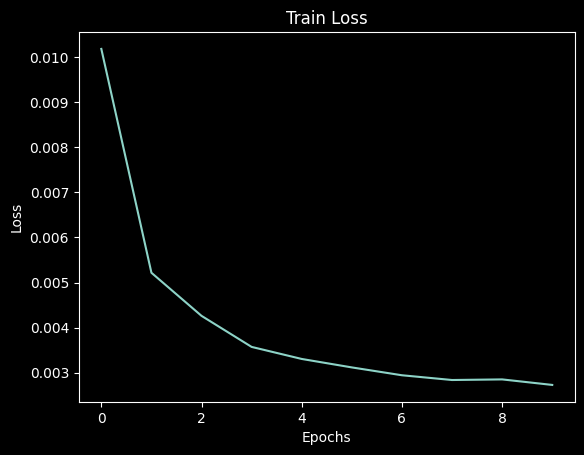

In [35]:
plt.figure()
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#### Test

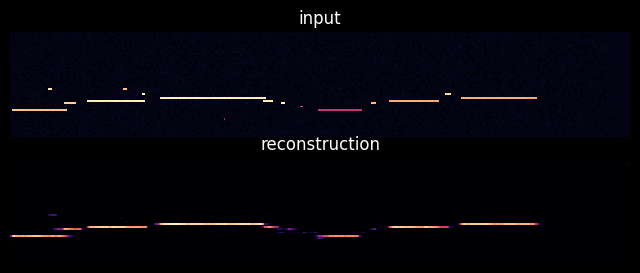

In [36]:
n_files = np.load(f"data/{output_filenames[0]}.npz")
d_files = np.load(f"data/{output_filenames[1]}.npz")

for (k1, v1), (k2, v2) in zip(n_files.items(), d_files.items()):
    compare_plot(v1, v2, "input", "reconstruction")

### Overfit Test

In [37]:
error

NameError: name 'error' is not defined

In [ ]:
overfit_set = [si_tensor[0]]
train_loss, output_filenames = train(model, overfit_set, overfit_set)
of_out = model(overfit_set[0][1].to(device))

compare_plot(overfit_set[0][1], of_out.cpu().data, "input", "reconstruction")

## Old

In [ ]:
error

In [ ]:
def test_image_reconstruction(net, testloader):
    for batch in testloader:
        img, _ = batch
        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0.0, 1.0)
        img_noisy = img_noisy.to(device)
        outputs = net(img_noisy)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(img_noisy, "noisy_test_input.png")
        save_image(outputs, "denoised_test_reconstruction.png")
        break

In [ ]:
def train_bak(net, trainLoader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                img, _ = data  # we do not need the image labels
                # add noise to the image data
                img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0.0, 1.0)
                img_noisy = img_noisy.to(device)
                optimizer.zero_grad()
                outputs = net(img_noisy)
                loss = loss_fn(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss)

            loss = running_loss / len(trainLoader)
            train_loss.append(loss)
            # print(f"Epoch {epoch} loss: {loss}")
            save_decoded_image(img_noisy.cpu().data, name="noisy{}".format(epoch))
            save_decoded_image(outputs.cpu().data, name="denoised{}".format(epoch))

    return train_loss